# **Proyecto Orange** 
### **Responsables: Andrés Felipe Ocampo, Alejandra Ruiz y Luis Felipe Montenegro**

# **Librerías**

In [1]:
! pip install dython

In [2]:
# --- Librerías estándar ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Estadística y pruebas ---
from scipy.stats import f_oneway, levene, shapiro
import scipy.stats as stats  # para otras funciones estadísticas

# --- Modelos y regresión ---
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import OrdinalEncoder

# --- Statsmodels para ANOVA y Tukey ---
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# --- Librerías específicas ---
import pingouin as pg  # pruebas estadísticas (e.g. kruskal, dunn)
from dython.nominal import identify_nominal_columns, identify_numeric_columns, correlation_ratio

# **Sección 1 - Cargue y transformación de dataset**

In [3]:
#Lectura de datos
df = pd.read_excel('prueba.xlsx', header=8)
pd.set_option('display.max_columns', None)

In [4]:
# Crear dataset para análisis
df_analysis = df.copy() 

# Renombrar columnas para facilitar análisis
df_analysis.rename(columns={
    '2 company size': 'Company size',
    '9 Last Year Sales': 'Last year sales',
    '3 Age of the company:': 'Age of company',
    '4 Geographic reach location:': 'Geographic reach location',
    '5 R&D Expenditure (Research and Development):': 'R&D expenditure',
    '6 new products sales:': 'New products sales',
    '7 Number of patents/innovations:': 'Number of patents innovations',
    '8 Annual growth:': 'Annual growth',
    "1 industry/sector:": "Industry/Sector"
}, inplace=True)

# Eliminar duplicados por empresa
df_analysis = df_analysis.drop_duplicates(subset=['Company'])

# Seleccionar columnas 1 a 15
df_analysis = df_analysis.iloc[:, 1:15]

# Dividir la columna de industria y sector
df_analysis[['Industry', 'Sector']] = df_analysis['Industry/Sector'].str.split(', ', n=1, expand=True)

# Limpiar y convertir 'New products sales'
df_analysis['New products sales'] = df_analysis['New products sales'].astype(str)
df_analysis['New products sales'] = df_analysis['New products sales'].str.replace(r'[\$,]', '', regex=True)
df_analysis['New products sales'] = df_analysis['New products sales'].str.replace('.', '', regex=False)
df_analysis['New products sales'] = df_analysis['New products sales'].astype(float)

# Cambiar a inglés los valores de las columnas "Industry" y "Sector"
# Diccionario de traducción
industry_translation = {
    "Manufactura": "Manufacturing",
    "Servicios": "Services",
    "Comercio": "Commerce"
}

sector_translation = {
    "Moda": "Fashion",
    "Construcción": "Construction",
    "Comidas y bebidas": "Food and Beverages",
    "Educación": "Education",
    "Automotor": "Automotive",
    "Belleza y cuidado personal": "Beauty and Personal Care",
    "Deportes": "Sports",
    "Empaques": "Packaging",
    "Energía": "Energy",
    "Ferroelectrico": "Ferroelectric",
    "Mejora de procesos": "Process Improvement",
    "Papelería": "Stationery",
    "Tecnología": "Technology",
    "Textiles": "Textiles",
    "Transporte y logística": "Transport and Logistics"
}

# Aplicar la traducción a Industry
df_analysis['Industry'] = df_analysis['Industry'].replace(industry_translation)

# Limpieza previa opcional: quitar espacios extra si hay
df_analysis['Sector'] = df_analysis['Sector'].str.strip()
# Unificar manualmente los duplicados (si hay diferencias de acento, mayúsculas, etc.)
df_analysis['Sector'] = df_analysis['Sector'].replace("Tecnología", "Tecnología")
# Aplicar traducción a sector
df_analysis['Sector'] = df_analysis['Sector'].replace(sector_translation)

# Cambiar a millones algunas variables
df_analysis['R&D expenditure (millions)']=df_analysis['R&D expenditure']/1_000_000
df_analysis['New products sales (millions)']=df_analysis['New products sales']/1_000_000
df_analysis['Last year sales (millions)']=df_analysis['Last year sales']/1_000_000

# Hacer transformación a porcentaje de variable "Annual growth"
df_analysis['Annual growth'] = df_analysis['Annual growth'].astype(float)
df_analysis['Annual growth (%)'] = (df_analysis['Annual growth'] * 100).round(1).astype(str) + '%'

# Vista previa
df_analysis.head(5)

,Company_number,LT \nLeader of Team)\n \nor\n \nTM \n(Team Member),CODE,Industry,Industry/Sector,Company size,Age of company,Age of the company (segment),Geographic reach location,R&D expenditure,New products sales,Number of patents innovations,Annual growth,Last year sales,Sector,R&D expenditure (millions),New products sales (millions),Last year sales (millions),Annual growth (%)
0,1,LT,C01-LT,Manufacturing,"Manufactura, Moda",Big,29,25+ years,Regional,2.000000e-02,1.785000e+10,12,0.18,85000000000,Fashion,2.000000e-08,17850.0,85000.0,18.0%
2,2,LT,C02-LT,Services,"Servicios, Comidas y bebidas",Big,6,5-8 years,National,1.037000e+09,2.835000e+09,8,0.24,94500000000,Food and Beverages,1.037000e+03,2835.0,94500.0,24.0%
4,3,LT,C03-LT,Manufacturing,"Manufactura, Moda",Big,8,5-8 years,Local,0.000000e+00,1.320000e+10,4,0.10,110000000000,Fashion,0.000000e+00,13200.0,110000.0,10.0%
6,4,LT,C04-LT,Services,"Servicios, Transporte y logística",Medium,23,15-25 years,International,1.200000e+09,4.800000e+09,6,0.15,13450000000,Transport and Logistics,1.200000e+03,4800.0,13450.0,15.0%
8,5,LT,C05-LT,Services,"Servicios, Tecnología",Medium,25,15-25 years,National,9.625000e+08,3.850000e+09,4,0.08,19250000000,Technology,9.625000e+02,3850.0,19250.0,8.0%


# **Sección 2 - Análisis Univariado**

## **2.1 Industry**

In [5]:
df_analysis['Industry'].describe()

count                28
unique                3
top       Manufacturing
freq                 14
Name: Industry, dtype: object

In [6]:
tabla_freq=(pd.crosstab(index=df_analysis["Industry"],columns="count")).reset_index()
tabla_freq['Freq. Rel.']=tabla_freq['count']/sum(tabla_freq['count'])
tabla_freq.rename(columns={'count':'Freq. Abs.'},inplace=True)
tabla_freq=tabla_freq.sort_values(by='Freq. Abs.',ascending=False).reset_index(drop=True)
tabla_freq

col_0,Industry,Freq. Abs.,Freq. Rel.
0,Manufacturing,14,0.500000
1,Services,8,0.285714
2,Commerce,6,0.214286


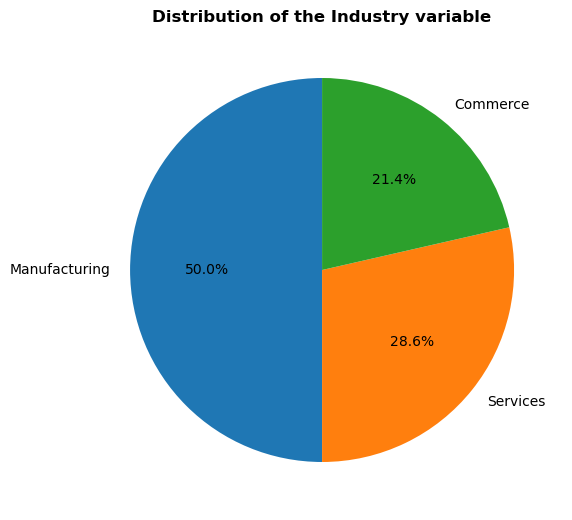

In [7]:
fig_torta = plt.figure() 
ax = fig_torta.add_axes([0,0,1,1])
plt.pie(tabla_freq["Freq. Rel."], labels=tabla_freq["Industry"],autopct='%1.1f%%',startangle=90)
plt.title("Distribution of the Industry variable", fontweight='bold')
plt.show()

## **2.2 Sector**

In [8]:
df_analysis['Sector'].describe()

count          28
unique         15
top       Fashion
freq            8
Name: Sector, dtype: object

In [9]:
tabla_freq=(pd.crosstab(index=df_analysis["Sector"],columns="count")).reset_index()
tabla_freq['Freq. Rel.']=tabla_freq['count']/sum(tabla_freq['count'])
tabla_freq.rename(columns={'count':'Freq. Abs.'},inplace=True)
tabla_freq=tabla_freq.sort_values(by='Freq. Abs.',ascending=False).reset_index(drop=True)
tabla_freq

col_0,Sector,Freq. Abs.,Freq. Rel.
0,Fashion,8,0.285714
1,Construction,4,0.142857
2,Education,2,0.071429
3,Food and Beverages,2,0.071429
4,Technology,2,0.071429
5,Automotive,1,0.035714
6,Beauty and Personal Care,1,0.035714
7,Energy,1,0.035714
8,Ferroelectric,1,0.035714
9,Packaging,1,0.035714


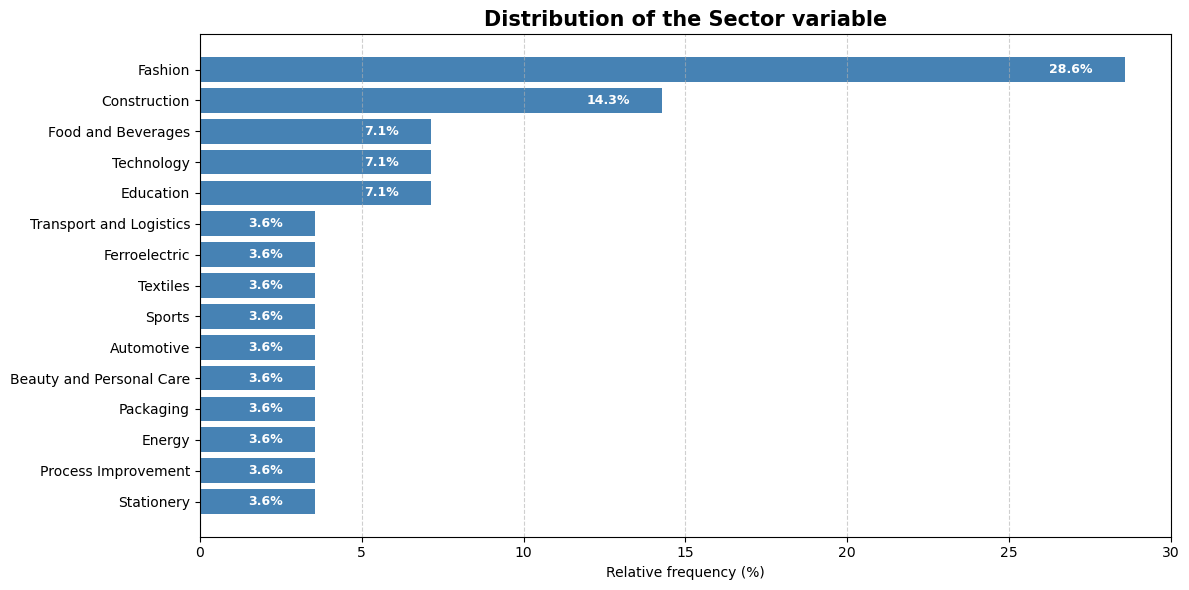

In [10]:
# Recalcular sector_freq_sorted por si se perdió en el contexto
sector_freq = df_analysis['Sector'].value_counts().reset_index()
sector_freq.columns = ['Sector', 'frecuencia_absoluta']
sector_freq['frecuencia_relativa'] = sector_freq['frecuencia_absoluta'] / sector_freq['frecuencia_absoluta'].sum()
sector_freq_sorted = sector_freq.sort_values(by="frecuencia_relativa", ascending=False)

# Crear el gráfico de barras con etiquetas al extremo derecho y en color blanco
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(
    sector_freq_sorted["Sector"],
    sector_freq_sorted["frecuencia_relativa"] * 100,
    color="#4682B4"
)

# Añadir etiquetas en blanco al final de cada barra
for bar in bars:
    width = bar.get_width()
    ax.text(width - 1, bar.get_y() + bar.get_height() / 2,
            f"{width:.1f}%", va='center', ha='right', color='white', fontsize=9, fontweight='bold')

# Configuración estética
ax.set_xlabel("Relative frequency (%)")
ax.set_title("Distribution of the Sector variable", fontsize=15, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## **2.3 Age of the company**

In [11]:
df_analysis['Age of company'].describe()

count    28.000000
mean     19.142857
std      12.270755
min       5.000000
25%       7.750000
50%      17.500000
75%      25.500000
max      47.000000
Name: Age of company, dtype: float64

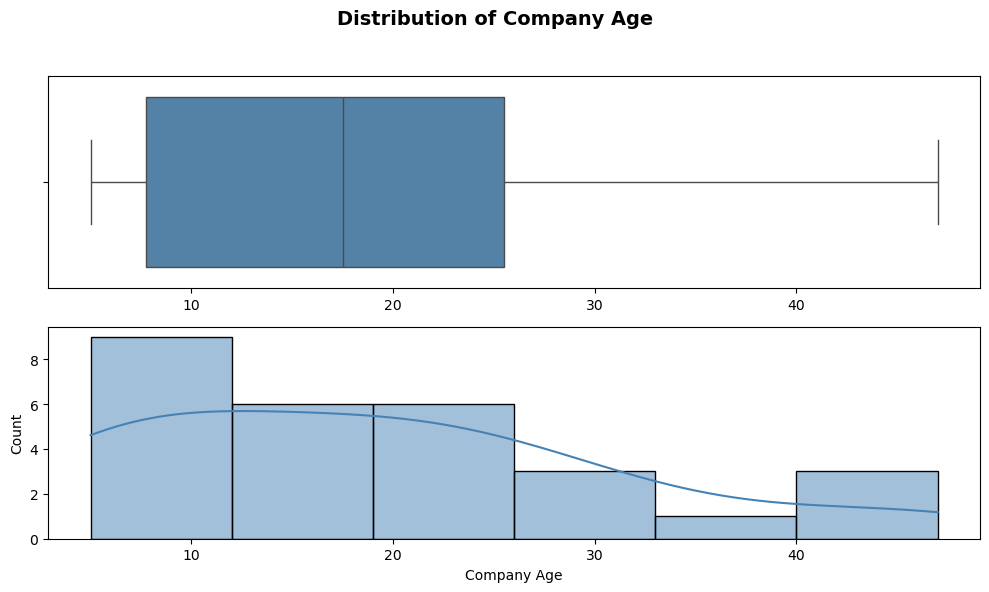

In [12]:
# Create figure with two subplots (one for boxplot and one for histogram)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
fig.suptitle("Distribution of Company Age",
             fontsize=14, fontweight='bold')

# Boxplot
sns.boxplot(x=df_analysis['Age of company'], color="steelblue", ax=axs[0])
axs[0].set_xlabel("")
# axs[0].set_title("Boxplot")

# Histogram with KDE
sns.histplot(df_analysis['Age of company'], kde=True, color="steelblue", ax=axs[1])
axs[1].set_xlabel("Company Age")
# axs[1].set_title("Histogram with KDE")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for the main title
plt.show()

## **2.4 Geographic location**

In [13]:
df_analysis['Geographic reach location'].describe()

count        28
unique        4
top       Local
freq         14
Name: Geographic reach location, dtype: object

In [14]:
tabla_freq=(pd.crosstab(index=df_analysis["Geographic reach location"],columns="count")).reset_index()
tabla_freq['Freq. Rel.']=tabla_freq['count']/sum(tabla_freq['count'])
tabla_freq.rename(columns={'count':'Freq. Abs.'},inplace=True)
tabla_freq=tabla_freq.sort_values(by='Freq. Abs.',ascending=False).reset_index(drop=True)
tabla_freq

col_0,Geographic reach location,Freq. Abs.,Freq. Rel.
0,Local,14,0.500000
1,National,9,0.321429
2,International,3,0.107143
3,Regional,2,0.071429


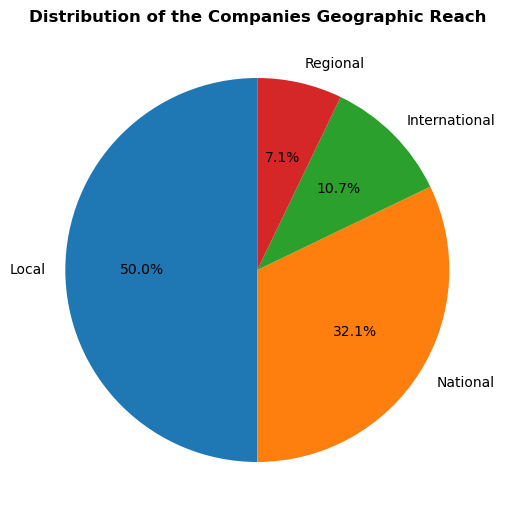

In [15]:
fig_pie = plt.figure() 
ax = fig_pie.add_axes([0, 0, 1, 1])

plt.pie(tabla_freq["Freq. Rel."],
        labels=tabla_freq["Geographic reach location"],
        autopct='%1.1f%%',
        startangle=90)

plt.title("Distribution of the Companies Geographic Reach", fontweight='bold')
plt.show()

## **2.5 R&D Expenditure**

In [16]:
df_analysis['R&D expenditure (millions)'].describe()

count      28.000000
mean      249.546429
std       428.326091
min         0.000000
25%         0.000000
50%        72.500000
75%       121.125000
max      1424.000000
Name: R&D expenditure (millions), dtype: float64

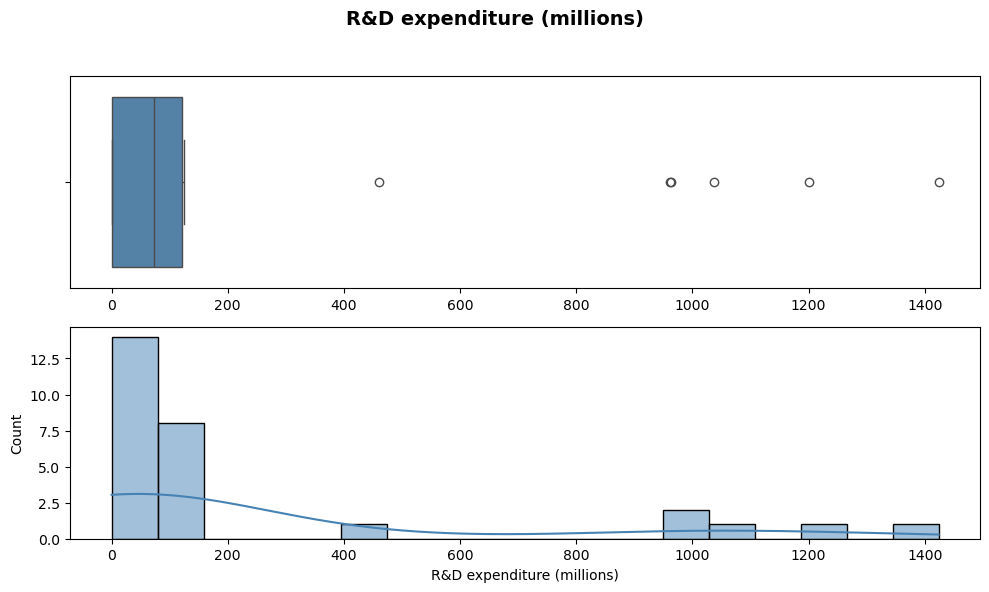

In [17]:
# Create figure with two subplots (one for boxplot and one for histogram)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
fig.suptitle("R&D expenditure (millions)",
             fontsize=14, fontweight='bold')

# Boxplot
sns.boxplot(x=df_analysis['R&D expenditure (millions)'], color="steelblue", ax=axs[0])
axs[0].set_xlabel("")
# axs[0].set_title("Boxplot")

# Histogram with KDE
sns.histplot(df_analysis['R&D expenditure (millions)'], kde=True, color="steelblue", ax=axs[1])
axs[1].set_xlabel("R&D expenditure (millions)")
# axs[1].set_title("Histogram with KDE")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for the main title
plt.show()

## **2.5 New product sales**

In [18]:
df_analysis['New products sales (millions)'].describe()

count       28.000000
mean      4657.911286
std       7936.571830
min          0.000000
25%         94.125000
50%       2118.000000
75%       4598.437500
max      36200.766000
Name: New products sales (millions), dtype: float64

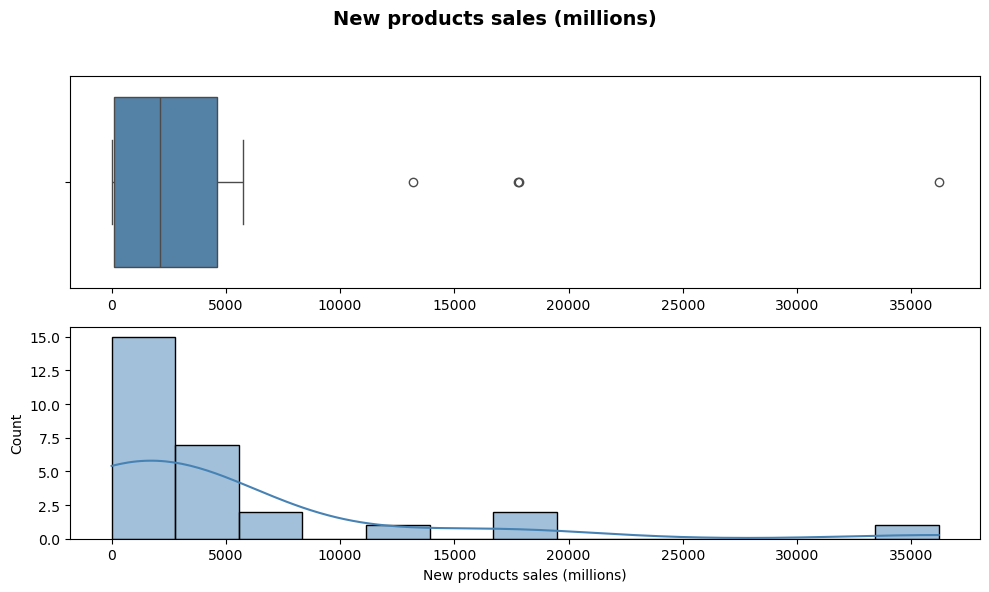

In [19]:
# Create figure with two subplots (one for boxplot and one for histogram)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
fig.suptitle("New products sales (millions)",
             fontsize=14, fontweight='bold')

# Boxplot
sns.boxplot(x=df_analysis['New products sales (millions)'], color="steelblue", ax=axs[0])
axs[0].set_xlabel("")
# axs[0].set_title("Boxplot")

# Histogram with KDE
sns.histplot(df_analysis['New products sales (millions)'], kde=True, color="steelblue", ax=axs[1])
axs[1].set_xlabel("New products sales (millions)")
# axs[1].set_title("Histogram with KDE")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for the main title
plt.show()

## **2.6 Number of patents innovations**

In [20]:
df_analysis['Number of patents innovations'].describe()

count    28.000000
mean      3.285714
std       2.706058
min       0.000000
25%       2.000000
50%       3.000000
75%       4.000000
max      12.000000
Name: Number of patents innovations, dtype: float64

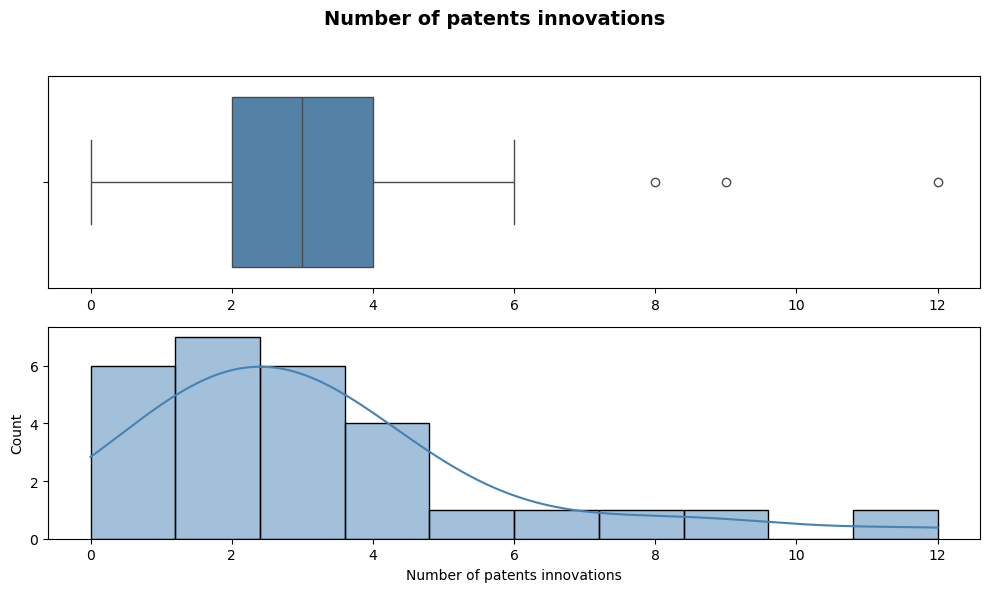

In [21]:
# Create figure with two subplots (one for boxplot and one for histogram)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
fig.suptitle("Number of patents innovations",
             fontsize=14, fontweight='bold')

# Boxplot
sns.boxplot(x=df_analysis['Number of patents innovations'], color="steelblue", ax=axs[0])
axs[0].set_xlabel("")
# axs[0].set_title("Boxplot")

# Histogram with KDE
sns.histplot(df_analysis['Number of patents innovations'], kde=True, color="steelblue", ax=axs[1])
axs[1].set_xlabel("Number of patents innovations")
# axs[1].set_title("Histogram with KDE")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for the main title
plt.show()

## **2.7 Last year sales (millions)**

In [22]:
df_analysis['Last year sales (millions)'].describe()

count        28.000000
mean      29441.167953
std       34884.050470
min         120.000000
25%        4567.500000
50%       14770.000000
75%       40937.500000
max      110000.000000
Name: Last year sales (millions), dtype: float64

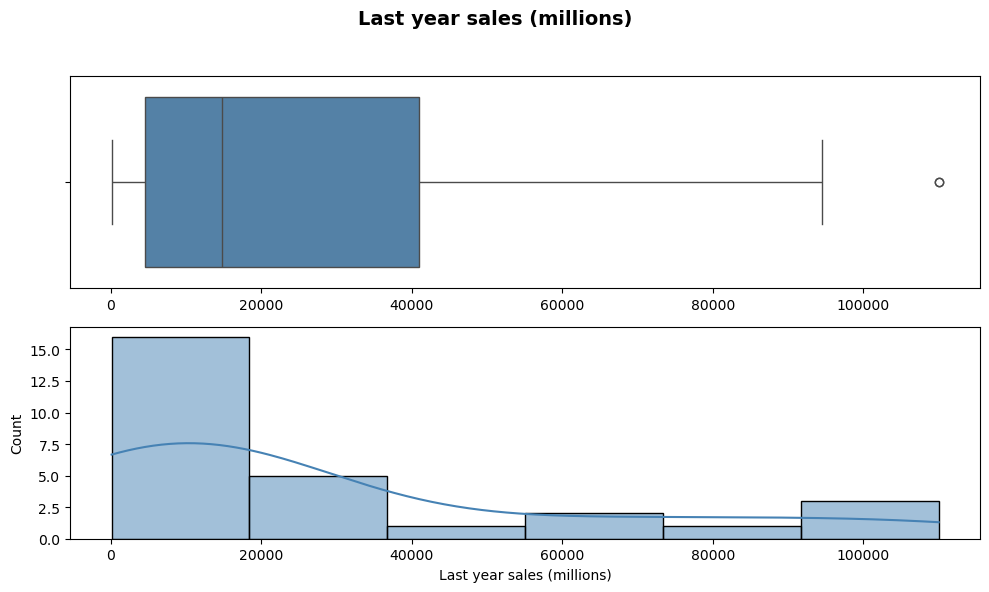

In [23]:
# Create figure with two subplots (one for boxplot and one for histogram)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
fig.suptitle("Last year sales (millions)",
             fontsize=14, fontweight='bold')

# Boxplot
sns.boxplot(x=df_analysis['Last year sales (millions)'], color="steelblue", ax=axs[0])
axs[0].set_xlabel("")
# axs[0].set_title("Boxplot")

# Histogram with KDE
sns.histplot(df_analysis['Last year sales (millions)'], kde=True, color="steelblue", ax=axs[1])
axs[1].set_xlabel("Last year sales (millions)")
# axs[1].set_title("Histogram with KDE")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for the main title
plt.show()

## **2.8 Company size**

In [24]:
df_analysis['Company size'].describe()

count         28
unique         4
top       Medium
freq          15
Name: Company size, dtype: object

In [25]:
tabla_freq=(pd.crosstab(index=df_analysis["Company size"],columns="count")).reset_index()
tabla_freq['Freq. Rel.']=tabla_freq['count']/sum(tabla_freq['count'])
tabla_freq.rename(columns={'count':'Freq. Abs.'},inplace=True)
tabla_freq=tabla_freq.sort_values(by='Freq. Abs.',ascending=False).reset_index(drop=True)
tabla_freq

col_0,Company size,Freq. Abs.,Freq. Rel.
0,Medium,15,0.535714
1,Small,5,0.178571
2,Big,4,0.142857
3,Micro,4,0.142857


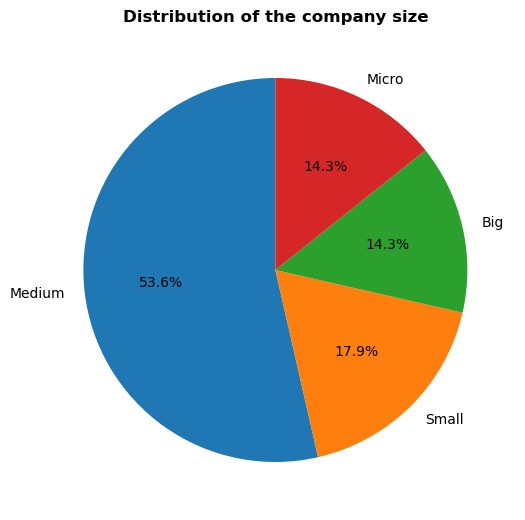

In [26]:
fig_pie = plt.figure() 
ax = fig_pie.add_axes([0, 0, 1, 1])

plt.pie(tabla_freq["Freq. Rel."],
        labels=tabla_freq["Company size"],
        autopct='%1.1f%%',
        startangle=90)

plt.title("Distribution of the company size", fontweight='bold')
plt.show()

## **2.9 Annual growth**

In [27]:
df_analysis["Annual growth"].describe()

count    28.000000
mean      0.125000
std       0.097696
min      -0.050000
25%       0.050000
50%       0.120000
75%       0.200000
max       0.400000
Name: Annual growth, dtype: float64

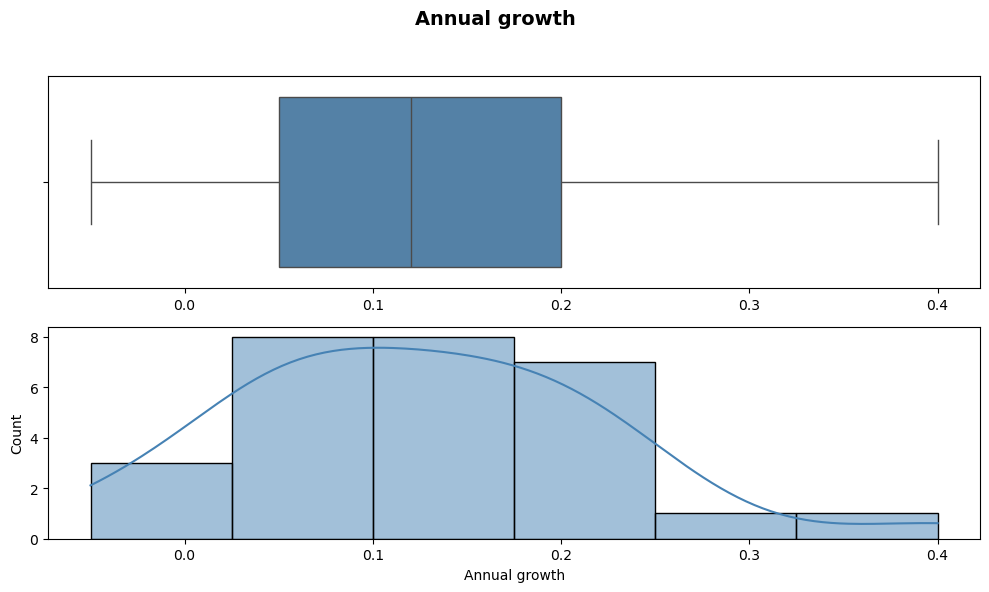

In [28]:
# Create figure with two subplots (one for boxplot and one for histogram)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
fig.suptitle("Annual growth",
             fontsize=14, fontweight='bold')

# Boxplot
sns.boxplot(x=df_analysis['Annual growth'], color="steelblue", ax=axs[0])
axs[0].set_xlabel("")
# axs[0].set_title("Boxplot")

# Histogram with KDE
sns.histplot(df_analysis['Annual growth'], kde=True, color="steelblue", ax=axs[1])
axs[1].set_xlabel("Annual growth")
# axs[1].set_title("Histogram with KDE")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for the main title
plt.show()

# **Sección 2 - Aplicación de modelo GRM y análisis bivariados**

## **2.1 Cargue de datos y ajuste de datasets**

In [29]:
df

,Company,Company_number,LT \nLeader of Team)\n \nor\n \nTM \n(Team Member),CODE,Industry,1 industry/sector:,2 company size,3 Age of the company:,Age of the company (segment),4 Geographic reach location:,5 R&D Expenditure (Research and Development):,6 new products sales:,7 Number of patents/innovations:,8 Annual growth:,9 Last Year Sales,1 status quo,2 Risk take,3 Creative Confidence,4 Questioning,5 Observing,6 Networking,7 Experimenting,8 associating,9 Analysis,10 planning,11 Detail oriented,12 Discipline,"Indicate how often your business identifies and defines performance challenges or opportunities, particularly in relation to customer acquisition.","Indicate how effective your business is to identify and define challenges or performance opportunities, particularly in relation to customer acquisition.","Indicate how often you participate in the identification and definition of challenges or opportunities for performance within your business development processes, particularly in relation to the acquisition of customers.","Indicate the typical level of certainty that you experience by identifying and defining challenges or opportunities for business development, particularly in relation to the acquisition of clients.",Indicate how often your business establishes clear objectives and performance priorities for the acquisition of customers in business development.,Indicate how effective your business to establish clear objectives and performance priorities for the acquisition of customers in business development.,Indicate how often you participate in establishing clear objectives and performance priorities for the acquisition of clients in business development.,Indicate the typical level of certainty that you experience when establishing clear objectives and performance priorities for the acquisition of clients in business development.,Income growth,Increased market share,Launch of new services and/or products,Geographical expansion,Investment return (ROI),Indicate how often your business identifies and defines innovation problems or opportunities to boost customer acquisition.,Indicate how effective your business is to identify and define problems of innovation or opportunities to promote customer acquisition.,Indicate how often you participate in the identification and definition of innovation problems or opportunities to boost customer acquisition.,Indicate the typical level of certainty that you experience by identifying and defining innovation problems or opportunities to boost customer acquisition.,Indicate how often your business establishes clear objectives and performance priorities in innovation for customer acquisition.,Indicate how effective your business is to establish clear objectives and performance priorities in innovation for customer acquisition.,Indicate how often you participate in establishing clear objectives and performance priorities in innovation for customer acquisition.,Indicate the typical level of certainty that you experience when establishing clear objectives and performance priorities in innovation for customer acquisition.,Launch of new services and/or products.1,R&D investment,Intellectual property,Market share and competitive advantage,Efficiency and cost savings:,Indicate how often your company identifies and defines value proposals for customer acquisition.,Indicate how effective your business to identify and define value proposals for customer acquisition.,Indicate how often you participate in the identification and definition of value proposals for customer acquisition.,Indicate the typical level of certainty that you experience by identifying and defining value proposals for customer acquisition.,Indicate how often your business establishes clear objectives and priorities for value proposals adapted for customer acquisition.,Indicate how effective your business to establish clear objectives and priorities for the proposals for adapted value for the acquisition of customers.,Indicate how 

In [30]:
# Cargue de datos de resultados del modelo GRM
df_grm=pd.read_excel("indices_grm_dimensiones_estandarizados.xlsx")

# Traer al dataset de resultados del modelo GRM las variables de  caracterización de las empresas
df_analysis_multivariate = df_grm.merge(
    df[["Company",'CODE',
       'Industry', '1 industry/sector:', '2 company size',
       '3 Age of the company:', 'Age of the company (segment)',
       '4 Geographic reach location:',
       '5 R&D Expenditure (Research and Development):',
       '6 new products sales:', '7 Number of patents/innovations:',
       '8 Annual growth:', '9 Last Year Sales']],
    on='CODE',
    how='left'
)

In [31]:
# Renombrar columnas para facilitar análisis
df_analysis_multivariate.rename(columns={
    '2 company size': 'Company size',
    '9 Last Year Sales': 'Last year sales',
    '3 Age of the company:': 'Age of company',
    '4 Geographic reach location:': 'Geographic reach location',
    '5 R&D Expenditure (Research and Development):': 'R&D expenditure',
    '6 new products sales:': 'New products sales',
    '7 Number of patents/innovations:': 'Number of patents innovations',
    '8 Annual growth:': 'Annual growth',
    "1 industry/sector:": "Industry/Sector"
}, inplace=True)

# Dividir la columna de industria y sector
df_analysis_multivariate[['Industry', 'Sector']] = df_analysis_multivariate['Industry/Sector'].str.split(', ', n=1, expand=True)

# Limpiar y convertir 'New products sales'
df_analysis_multivariate['New products sales'] = df_analysis_multivariate['New products sales'].astype(str)
df_analysis_multivariate['New products sales'] = df_analysis_multivariate['New products sales'].str.replace(r'[\$,]', '', regex=True)
df_analysis_multivariate['New products sales'] = df_analysis_multivariate['New products sales'].str.replace('.', '', regex=False)
df_analysis_multivariate['New products sales'] = df_analysis_multivariate['New products sales'].astype(float)

# Cambiar a inglés los valores de las columnas "Industry" y "Sector"
# Diccionario de traducción
industry_translation = {
    "Manufactura": "Manufacturing",
    "Servicios": "Services",
    "Comercio": "Commerce"
}

sector_translation = {
    "Moda": "Fashion",
    "Construcción": "Construction",
    "Comidas y bebidas": "Food and Beverages",
    "Educación": "Education",
    "Automotor": "Automotive",
    "Belleza y cuidado personal": "Beauty and Personal Care",
    "Deportes": "Sports",
    "Empaques": "Packaging",
    "Energía": "Energy",
    "Ferroelectrico": "Ferroelectric",
    "Mejora de procesos": "Process Improvement",
    "Papelería": "Stationery",
    "Tecnología": "Technology",
    "Textiles": "Textiles",
    "Transporte y logística": "Transport and Logistics"
}

# Aplicar la traducción a Industry
df_analysis_multivariate['Industry'] = df_analysis_multivariate['Industry'].replace(industry_translation)

# Limpieza previa opcional: quitar espacios extra si hay
df_analysis_multivariate['Sector'] = df_analysis_multivariate['Sector'].str.strip()
# Unificar manualmente los duplicados (si hay diferencias de acento, mayúsculas, etc.)
df_analysis_multivariate['Sector'] = df_analysis_multivariate['Sector'].replace("Tecnología", "Tecnología")
# Aplicar traducción a sector
df_analysis_multivariate['Sector'] = df_analysis_multivariate['Sector'].replace(sector_translation)

# Cambiar a millones algunas variables
df_analysis_multivariate['R&D expenditure (millions)']=df_analysis_multivariate['R&D expenditure']/1_000_000
df_analysis_multivariate['New products sales (millions)']=df_analysis_multivariate['New products sales']/1_000_000
df_analysis_multivariate['Last year sales (millions)']=df_analysis_multivariate['Last year sales']/1_000_000

# Hacer transformación a porcentaje de variable "Annual growth"
df_analysis_multivariate['Annual growth'] = df_analysis_multivariate['Annual growth'].astype(float)
df_analysis_multivariate['Annual growth (%)'] = (df_analysis_multivariate['Annual growth'] * 100).round(1).astype(str) + '%'

# Vista previa
df_analysis_multivariate.head(5)

,CODE,Indice_Sensing,Indice_Seizing,Indice_Transformation,Indice_Sensing_Z,Indice_Seizing_Z,Indice_Transformation_Z,Company,Industry,Industry/Sector,Company size,Age of company,Age of the company (segment),Geographic reach location,R&D expenditure,New products sales,Number of patents innovations,Annual growth,Last year sales,Sector,R&D expenditure (millions),New products sales (millions),Last year sales (millions),Annual growth (%)
0,C01-LT,1.584394,1.302203,1.820393,1.584908,1.307669,1.822736,C01,Manufacturing,"Manufactura, Moda",Big,29,25+ years,Regional,2.000000e-02,1.785000e+10,12,0.18,85000000000,Fashion,2.000000e-08,17850.0,85000.0,18.0%
1,C01-TM,1.613900,1.308076,1.837790,1.614417,1.313544,1.840152,C01,Manufacturing,"Manufactura, Moda",Big,29,25+ years,Regional,2.000000e-02,1.785000e+10,12,0.18,85000000000,Fashion,2.000000e-08,17850.0,85000.0,18.0%
2,C02-LT,0.475348,0.439359,0.792505,0.475718,0.444613,0.793801,C02,Services,"Servicios, Comidas y bebidas",Big,6,5-8 years,National,1.037000e+09,2.835000e+09,8,0.24,94500000000,Food and Beverages,1.037000e+03,2835.0,94500.0,24.0%
3,C02-TM,0.515720,0.432376,0.798164,0.516096,0.437629,0.799466,C02,Services,"Servicios, Comidas y bebidas",Big,6,5-8 years,National,1.037000e+09,2.835000e+09,8,0.24,94500000000,Food and Beverages,1.037000e+03,2835.0,94500.0,24.0%
4,C03-LT,0.421892,0.641390,0.577742,0.422256,0.646694,0.578820,C03,Manufacturing,"Manufactura, Moda",Big,8,5-8 years,Local,0.000000e+00,1.320000e+10,4,0.10,110000000000,Fashion,0.000000e+00,13200.0,110000.0,10.0%


In [32]:
# Promediar los valores de variables latentes por cada compañía
# Agrupar por empresa y calcular promedios de los índices latentes y sus z-scores
df_analysis_multivariate_final = df_analysis_multivariate.groupby('Company').agg({
    'Indice_Sensing': 'mean',
    'Indice_Seizing': 'mean',
    'Indice_Transformation': 'mean',
    'Indice_Sensing_Z': 'mean',
    'Indice_Seizing_Z': 'mean',
    'Indice_Transformation_Z': 'mean',
    'Company size': 'first',
    'Industry': 'first',
    'Sector': 'first',
    "Last year sales": 'first',
    "Age of company":"first",
    "Geographic reach location": 'first',
    "R&D expenditure": 'first',
    "New products sales": 'first',
    "Number of patents innovations": 'first',
    "Annual growth": 'first'
}).reset_index()

## **2.2 Análisis bivariados - Índice Sensing**

### **2.2.1 Tamaño de la empresa**

#### **Comprobación de normalidad de los datos**

In [33]:
# Aplicar Shapiro-Wilk a cada grupo
for group in df_analysis_multivariate_final['Company size'].unique():
    datos_grupo = df_analysis_multivariate_final[df_analysis_multivariate_final['Company size'] == group]['Indice_Sensing']
    stat, p = shapiro(datos_grupo)
    print(f"\nGrupo: {group}")
    print(f"Estadístico Shapiro-Wilk: {stat:.4f}, p-valor: {p:.4f}")
    if p < 0.05:
        print("→ No es normal (rechaza H0)")
    else:
        print("→ Normal (no rechaza H0)")


Grupo: Big
Estadístico Shapiro-Wilk: 0.9166, p-valor: 0.5178
→ Normal (no rechaza H0)

Grupo: Medium
Estadístico Shapiro-Wilk: 0.9561, p-valor: 0.6249
→ Normal (no rechaza H0)

Grupo: Small
Estadístico Shapiro-Wilk: 0.9295, p-valor: 0.5929
→ Normal (no rechaza H0)

Grupo: Micro
Estadístico Shapiro-Wilk: 0.9628, p-valor: 0.7965
→ Normal (no rechaza H0)


#### **Comprobación de homogeneidad de varianzas**

In [34]:
# Agrupar los datos por grupo
grupos = df_analysis_multivariate_final['Company size'].unique()
datos_por_grupo = [df_analysis_multivariate_final[df_analysis_multivariate_final['Company size'] == g]['Indice_Sensing'] for g in grupos]

# Aplicar prueba de Levene
stat, p = levene(*datos_por_grupo)
print(f"Estadístico Levene: {stat:.4f}, p-valor: {p:.4f}")

if p < 0.05:
    print("→ Varianzas diferentes (rechaza H0)")
else:
    print("→ Varianzas iguales (no rechaza H0)")

Estadístico Levene: 0.9367, p-valor: 0.4383
→ Varianzas iguales (no rechaza H0)


#### **Aplicación de pruebas estadísticas para revisión de diferencias entre medianas**


Classical ANOVA results:
F-statistic: 12.5298
P-value: 0.0000

ANOVA is significant (p < 0.05). Applying Tukey HSD test...


C:\Users\1144094695\AppData\Local\Temp\ipykernel_23816\2087559377.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Company size', y='Indice_Sensing', data=df_analysis_multivariate_final,


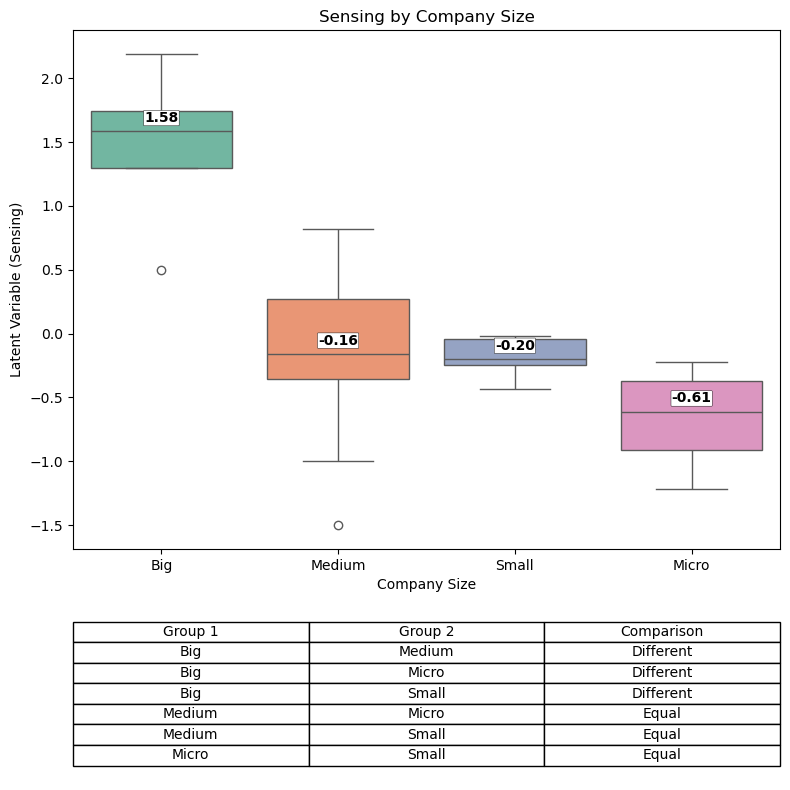

In [35]:
# 1. Classical ANOVA
groups = df_analysis_multivariate_final.groupby('Company size')['Indice_Sensing'].apply(list)
f_stat, p_value = f_oneway(*groups)

print("\nClassical ANOVA results:")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# 2. Check if significant
if p_value < 0.05:
    print("\nANOVA is significant (p < 0.05). Applying Tukey HSD test...")

    # 3. Tukey HSD post-hoc test
    tukey = pairwise_tukeyhsd(endog=df_analysis_multivariate_final['Indice_Sensing'],
                              groups=df_analysis_multivariate_final['Company size'],
                              alpha=0.05)
    tukey_summary = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
    tukey_summary['Interpretation'] = tukey_summary['p-adj'].apply(lambda x: 'Different' if x < 0.05 else 'Equal')

    # 4. Compute medians by group and sort
    medians = df_analysis_multivariate_final.groupby('Company size')['Indice_Sensing'].median().reset_index()
    category_order = medians.sort_values('Indice_Sensing', ascending=False)['Company size'].tolist()

    # 5. Create figure (boxplot + table)
    fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]})

    sns.boxplot(x='Company size', y='Indice_Sensing', data=df_analysis_multivariate_final,
                ax=ax[0], palette="Set2", order=category_order)
    ax[0].set_title("Sensing by Company Size")
    ax[0].set_xlabel("Company Size")
    ax[0].set_ylabel("Latent Variable (Sensing)")

    # Annotate medians
    for i, row in medians.iterrows():
        idx = category_order.index(row['Company size'])
        offset = 0.05
        ax[0].text(idx, row['Indice_Sensing'] + offset, 
                   f"{row['Indice_Sensing']:.2f}", 
                   ha='center', va='bottom', fontweight='bold', color='black',
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.05', linewidth=0.3))

    # 6. Add table below the plot
    table = tukey_summary[['group1', 'group2', 'Interpretation']]
    ax[1].axis('off')
    table_text = table.values.tolist()
    column_labels = ['Group 1', 'Group 2', 'Comparison']
    ax[1].table(cellText=table_text, colLabels=column_labels, loc='center', cellLoc='center')

    plt.tight_layout()
    plt.show()

else:
    print("\nANOVA is not significant (p ≥ 0.05). Tukey HSD test and plot will not be generated.")


### **2.2.2 Ventas de la empresa**

In [36]:
df_analysis_multivariate_final["Last year sales"]=df_analysis_multivariate_final["Last year sales"]/1_000_000

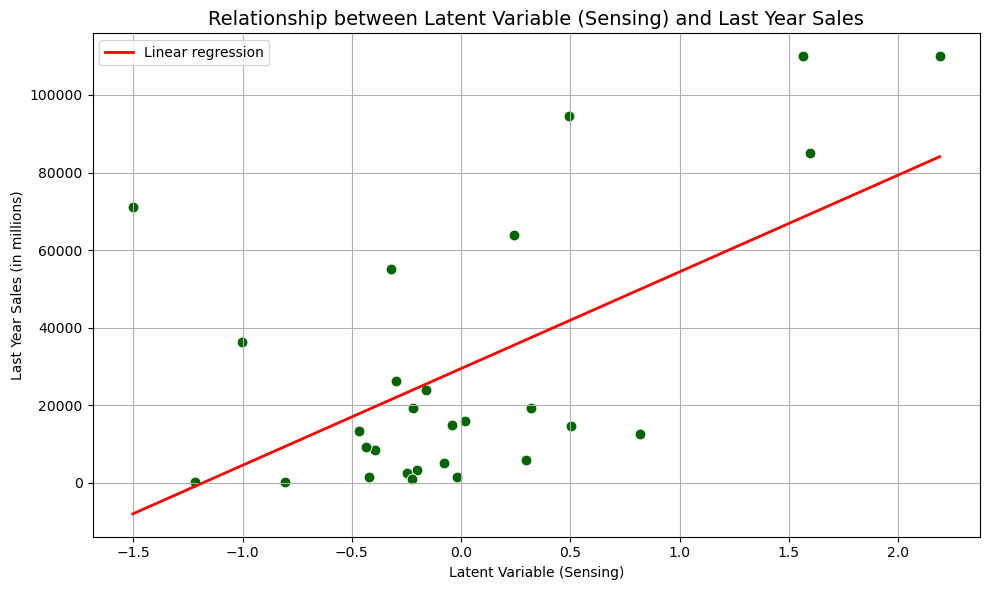

In [37]:
# Specific variables
df_plot = df_analysis_multivariate_final.copy()
x_var = "Indice_Sensing"
y_var = "Last year sales"

# Fit linear regression model
X = df_plot[[x_var]]  # design matrix (2D)
y = df_plot[y_var]
model = LinearRegression().fit(X, y)

# Predict values and compute R²
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_var, y=y_var, data=df_plot, color='darkgreen', s=60)
sns.lineplot(x=df_plot[x_var], y=y_pred, color='red', linewidth=2, label='Linear regression')

# Customize labels and title
plt.title("Relationship between Latent Variable (Sensing) and Last Year Sales", fontsize=14)
plt.xlabel("Latent Variable (Sensing)")
plt.ylabel("Last Year Sales (in millions)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
df_promedio_empresa_corr=df_analysis_multivariate_final.copy()

# Cammbio de nombre de Indice_Sensing
df_promedio_empresa_corr.rename(columns={'Indice_Sensing': 'Latent variable (Sensing)'}, inplace=True)

# Elegir las columnas que se desean analizar
df_promedio_empresa_corr = df_promedio_empresa_corr[["Latent variable (Sensing)","Company size","Last year sales"]]

categorical_features=identify_nominal_columns(df_promedio_empresa_corr)
continuous_features=identify_numeric_columns(df_promedio_empresa_corr)

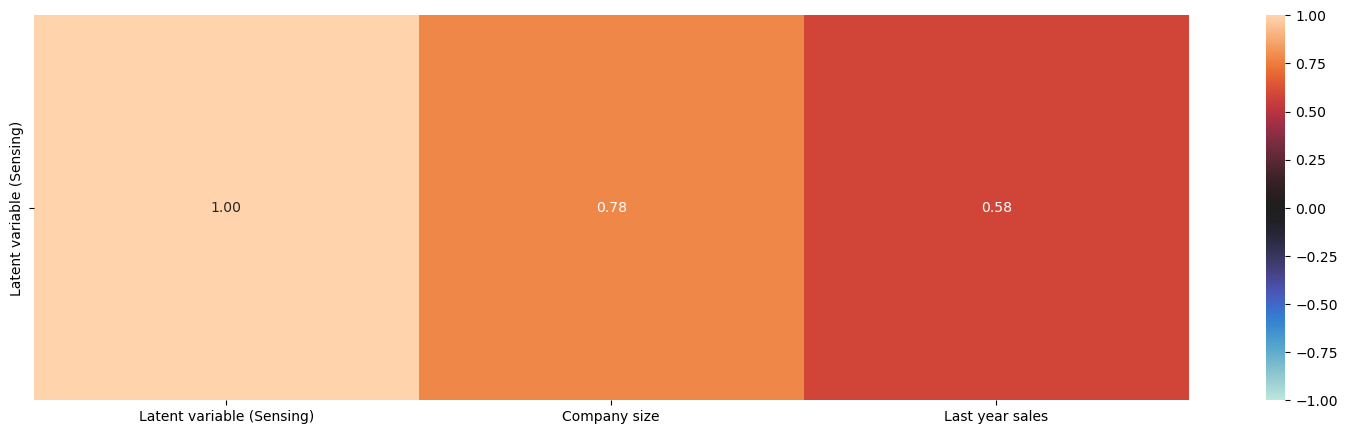

In [39]:
from dython.nominal import associations
target_correlation= associations(df_promedio_empresa_corr, display_rows=["Latent variable (Sensing)"], filename= 'target_correlation.png', figsize=(20,5))

In [40]:
df_analysis_multivariate_final

,Company,Indice_Sensing,Indice_Seizing,Indice_Transformation,Indice_Sensing_Z,Indice_Seizing_Z,Indice_Transformation_Z,Company size,Industry,Sector,Last year sales,Age of company,Geographic reach location,R&D expenditure,New products sales,Number of patents innovations,Annual growth
0,C01,1.599147,1.305140,1.829091,1.599663,1.310607,1.831444,Big,Manufacturing,Fashion,85000.000000,29,Regional,2.000000e-02,1.785000e+10,12,0.18
1,C02,0.495534,0.435867,0.795335,0.495907,0.441121,0.796633,Big,Services,Food and Beverages,94500.000000,6,National,1.037000e+09,2.835000e+09,8,0.24
2,C03,1.566232,1.703583,1.637924,1.566743,1.709148,1.640082,Big,Manufacturing,Fashion,110000.000000,8,Local,0.000000e+00,1.320000e+10,4,0.10
3,C04,-0.467213,-0.401244,-0.331791,-0.466963,-0.396196,-0.331641,Medium,Services,Transport and Logistics,13450.000000,23,International,1.200000e+09,4.800000e+09,6,0.15
4,C05,0.318504,0.533603,0.398109,0.318855,0.538881,0.399003,Medium,Services,Technology,19250.000000,25,National,9.625000e+08,3.850000e+09,4,0.08
5,C06,-1.502069,-1.351313,-1.699216,-1.501954,-1.346499,-1.700460,Medium,Manufacturing,Construction,71200.000000,30,National,1.424000e+09,1.780000e+10,4,0.26
6,C07,0.241241,0.006293,-0.390087,0.241581,0.011441,-0.389997,Medium,Manufacturing,Construction,64000.000000,40,National,1.000000e+07,3.620077e+10,3,0.20
7,C08,-0.200324,-0.130438,0.592535,-0.200041,-0.125323,0.593628,Small,Manufacturing,Fashion,3270.000000,12,National,9.810000e+07,3.270000e+08,3,0.12
8,C09,2.190476,2.629447,2.181530,2.191067,2.635239,2.184242,Big,Commerce,Ferroelectric,110000.000000,24,International,1.200000e+08,2.600000e+08,2,0.14
9,C10,0.501075,-0.009984,0.578918,0.501449,-0.004840,0.579997,Medium,Manufacturing,Fashion,14760.000000,21,Local,1.000000e+08,1.476000e+09,3,-0.03


In [41]:
df_promedio_empresa_reg_lineal = df_analysis_multivariate_final[["Indice_Sensing","Last year sales"]]

x=df_promedio_empresa_reg_lineal.drop(["Last year sales"], axis=1)
y=df_promedio_empresa_reg_lineal["Last year sales"]
X = sm.add_constant(x) 
model = sm.OLS(y,X)
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Last year sales   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     13.20
Date:                Sun, 01 Jun 2025   Prob (F-statistic):            0.00121
Time:                        17:49:47   Log-Likelihood:                -326.35
No. Observations:                  28   AIC:                             656.7
Df Residuals:                      26   BIC:                             659.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.945e+04   5471.517      5.382      0.000    1.82e+04    4.07e+04
Indice_Sensing  2.494e+04   6865.745      3.633      0.001    1.08e+04    3.91e+04
==============================================================================
Omnibus:                        6.971   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                5.490
Skew:                           1.060   Prob(JB):                       0.0643
Kurtosis:                       3.463   Cond. No.                         1.25
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## **2.3 Análisis bivariados - Índice Seizing**

### **2.3.1 Tamaño de la empresa**

#### **Comprobación de normalidad de los datos**

In [42]:
# Aplicar Shapiro-Wilk a cada grupo
for group in df_analysis_multivariate_final['Company size'].unique():
    datos_grupo = df_analysis_multivariate_final[df_analysis_multivariate_final['Company size'] == group]['Indice_Seizing']
    stat, p = shapiro(datos_grupo)
    print(f"\nGrupo: {group}")
    print(f"Estadístico Shapiro-Wilk: {stat:.4f}, p-valor: {p:.4f}")
    if p < 0.05:
        print("→ No es normal (rechaza H0)")
    else:
        print("→ Normal (no rechaza H0)")


Grupo: Big
Estadístico Shapiro-Wilk: 0.9963, p-valor: 0.9872
→ Normal (no rechaza H0)

Grupo: Medium
Estadístico Shapiro-Wilk: 0.9396, p-valor: 0.3776
→ Normal (no rechaza H0)

Grupo: Small
Estadístico Shapiro-Wilk: 0.9577, p-valor: 0.7922
→ Normal (no rechaza H0)

Grupo: Micro
Estadístico Shapiro-Wilk: 0.8819, p-valor: 0.3469
→ Normal (no rechaza H0)


#### **Comprobación de homogeneidad de varianzas**

In [43]:
# Agrupar los datos por grupo
grupos = df_analysis_multivariate_final['Company size'].unique()
datos_por_grupo = [df_analysis_multivariate_final[df_analysis_multivariate_final['Company size'] == g]['Indice_Seizing'] for g in grupos]

# Aplicar prueba de Levene
stat, p = levene(*datos_por_grupo)
print(f"Estadístico Levene: {stat:.4f}, p-valor: {p:.4f}")

if p < 0.05:
    print("→ Varianzas diferentes (rechaza H0)")
else:
    print("→ Varianzas iguales (no rechaza H0)")

Estadístico Levene: 2.4280, p-valor: 0.0901
→ Varianzas iguales (no rechaza H0)


#### **Aplicación de pruebas estadísticas para revisión de diferencias entre medianas**


Classical ANOVA results:
F-statistic: 9.6422
P-value: 0.0002

ANOVA is significant (p < 0.05). Applying Tukey HSD test...


C:\Users\1144094695\AppData\Local\Temp\ipykernel_23816\2646848344.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Company size', y='Indice_Seizing', data=df_analysis_multivariate_final,


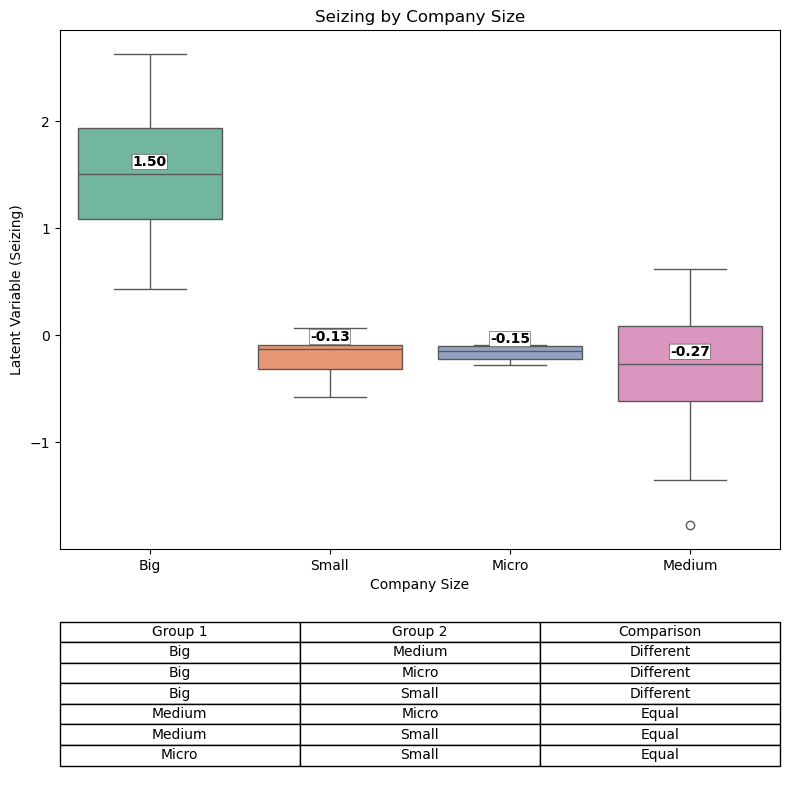

In [44]:
# 1. Classical ANOVA
groups = df_analysis_multivariate_final.groupby('Company size')['Indice_Seizing'].apply(list)
f_stat, p_value = f_oneway(*groups)

print("\nClassical ANOVA results:")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# 2. Check if significant
if p_value < 0.05:
    print("\nANOVA is significant (p < 0.05). Applying Tukey HSD test...")

    # 3. Tukey HSD post-hoc test
    tukey = pairwise_tukeyhsd(endog=df_analysis_multivariate_final['Indice_Seizing'],
                              groups=df_analysis_multivariate_final['Company size'],
                              alpha=0.05)
    tukey_summary = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
    tukey_summary['Interpretation'] = tukey_summary['p-adj'].apply(lambda x: 'Different' if x < 0.05 else 'Equal')

    # 4. Compute medians by group and sort
    medians = df_analysis_multivariate_final.groupby('Company size')['Indice_Seizing'].median().reset_index()
    category_order = medians.sort_values('Indice_Seizing', ascending=False)['Company size'].tolist()

    # 5. Create figure (boxplot + table)
    fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]})

    sns.boxplot(x='Company size', y='Indice_Seizing', data=df_analysis_multivariate_final,
                ax=ax[0], palette="Set2", order=category_order)
    ax[0].set_title("Seizing by Company Size")
    ax[0].set_xlabel("Company Size")
    ax[0].set_ylabel("Latent Variable (Seizing)")

    # Annotate medians
    for i, row in medians.iterrows():
        idx = category_order.index(row['Company size'])
        offset = 0.05
        ax[0].text(idx, row['Indice_Seizing'] + offset, 
                   f"{row['Indice_Seizing']:.2f}", 
                   ha='center', va='bottom', fontweight='bold', color='black',
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.05', linewidth=0.3))

    # 6. Add table below the plot
    table = tukey_summary[['group1', 'group2', 'Interpretation']]
    ax[1].axis('off')
    table_text = table.values.tolist()
    column_labels = ['Group 1', 'Group 2', 'Comparison']
    ax[1].table(cellText=table_text, colLabels=column_labels, loc='center', cellLoc='center')

    plt.tight_layout()
    plt.show()

else:
    print("\nANOVA is not significant (p ≥ 0.05). Tukey HSD test and plot will not be generated.")


### **2.3.2 Ventas de la empresa**

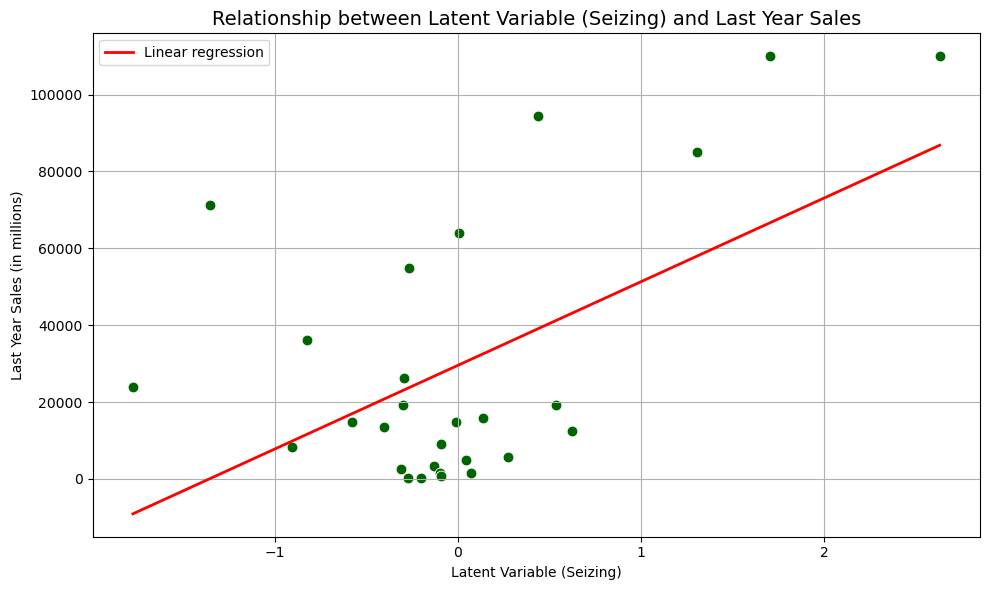

In [45]:
# Specific variables
df_plot = df_analysis_multivariate_final.copy()
x_var = "Indice_Seizing"
y_var = "Last year sales"

# Fit linear regression model
X = df_plot[[x_var]]  # design matrix (2D)
y = df_plot[y_var]
model = LinearRegression().fit(X, y)

# Predict values and compute R²
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_var, y=y_var, data=df_plot, color='darkgreen', s=60)
sns.lineplot(x=df_plot[x_var], y=y_pred, color='red', linewidth=2, label='Linear regression')

# Customize labels and title
plt.title("Relationship between Latent Variable (Seizing) and Last Year Sales", fontsize=14)
plt.xlabel("Latent Variable (Seizing)")
plt.ylabel("Last Year Sales (in millions)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [46]:
df_promedio_empresa_corr=df_analysis_multivariate_final.copy()

# Cammbio de nombre de Indice_Sensing
df_promedio_empresa_corr.rename(columns={'Indice_Seizing': 'Latent variable (Seizing)'}, inplace=True)

# Elegir las columnas que se desean analizar
df_promedio_empresa_corr = df_promedio_empresa_corr[["Latent variable (Seizing)","Company size","Last year sales"]]

categorical_features=identify_nominal_columns(df_promedio_empresa_corr)
continuous_features=identify_numeric_columns(df_promedio_empresa_corr)

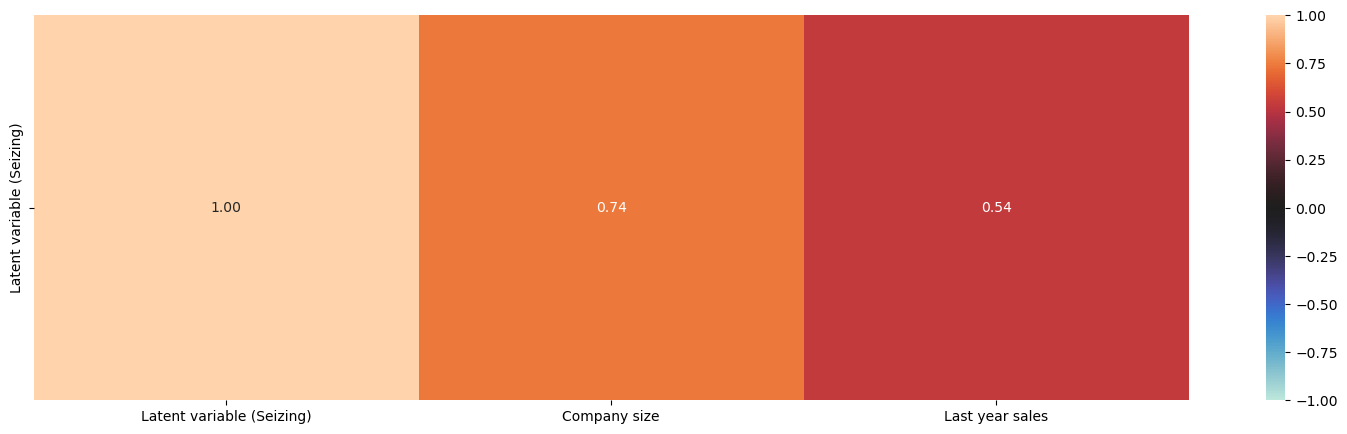

In [47]:
from dython.nominal import associations
target_correlation= associations(df_promedio_empresa_corr, display_rows=["Latent variable (Seizing)"], filename= 'target_correlation.png', figsize=(20,5))

In [48]:
df_promedio_empresa_reg_lineal = df_analysis_multivariate_final[["Indice_Seizing","Last year sales"]]

x=df_promedio_empresa_reg_lineal.drop(["Last year sales"], axis=1)
y=df_promedio_empresa_reg_lineal["Last year sales"]
X = sm.add_constant(x) 
model = sm.OLS(y,X)
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Last year sales   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     10.52
Date:              dom., 01 jun. 2025   Prob (F-statistic):            0.00323
Time:                        17:52:13   Log-Likelihood:                -327.34
No. Observations:                  28   AIC:                             658.7
Df Residuals:                      26   BIC:                             661.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.955e+04   5668.290      5.214      0.000    1.79e+04    4.12e+04
Indice_Seizing  2.178e+04   6714.161      3.244      0.003    7979.479    3.56e+04
==============================================================================
Omnibus:                        3.886   Durbin-Watson:                   1.496
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                3.469
Skew:                           0.824   Prob(JB):                        0.177
Kurtosis:                       2.492   Cond. No.                         1.18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## **2.4 Análisis bivariados - Índice Transformation**

#### **Comprobación de normalidad de los datos**

In [49]:
# Aplicar Shapiro-Wilk a cada grupo
for group in df_analysis_multivariate_final['Company size'].unique():
    datos_grupo = df_analysis_multivariate_final[df_analysis_multivariate_final['Company size'] == group]['Indice_Transformation']
    stat, p = shapiro(datos_grupo)
    print(f"\nGrupo: {group}")
    print(f"Estadístico Shapiro-Wilk: {stat:.4f}, p-valor: {p:.4f}")
    if p < 0.05:
        print("→ No es normal (rechaza H0)")
    else:
        print("→ Normal (no rechaza H0)")


Grupo: Big
Estadístico Shapiro-Wilk: 0.9327, p-valor: 0.6105
→ Normal (no rechaza H0)

Grupo: Medium
Estadístico Shapiro-Wilk: 0.9145, p-valor: 0.1587
→ Normal (no rechaza H0)

Grupo: Small
Estadístico Shapiro-Wilk: 0.9744, p-valor: 0.9025
→ Normal (no rechaza H0)

Grupo: Micro
Estadístico Shapiro-Wilk: 0.9172, p-valor: 0.5215
→ Normal (no rechaza H0)


#### **Comprobación de homogeneidad de varianzas**

In [50]:
# Agrupar los datos por grupo
grupos = df_analysis_multivariate_final['Company size'].unique()
datos_por_grupo = [df_analysis_multivariate_final[df_analysis_multivariate_final['Company size'] == g]['Indice_Transformation'] for g in grupos]

# Aplicar prueba de Levene
stat, p = levene(*datos_por_grupo)
print(f"Estadístico Levene: {stat:.4f}, p-valor: {p:.4f}")

if p < 0.05:
    print("→ Varianzas diferentes (rechaza H0)")
else:
    print("→ Varianzas iguales (no rechaza H0)")

Estadístico Levene: 0.6702, p-valor: 0.5786
→ Varianzas iguales (no rechaza H0)


#### **Aplicación de pruebas estadísticas para revisión de diferencias entre medianas**


Classical ANOVA results:
F-statistic: 12.7567
P-value: 0.0000

ANOVA is significant (p < 0.05). Applying Tukey HSD test...


C:\Users\1144094695\AppData\Local\Temp\ipykernel_23816\2455838220.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Company size', y='Indice_Transformation', data=df_analysis_multivariate_final,


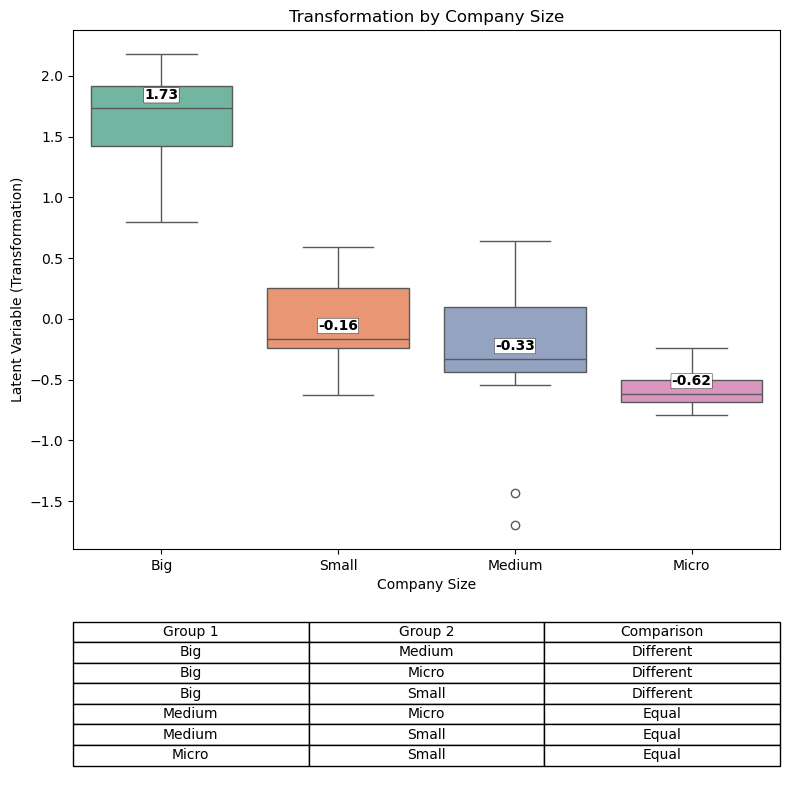

In [51]:
# 1. Classical ANOVA
groups = df_analysis_multivariate_final.groupby('Company size')['Indice_Transformation'].apply(list)
f_stat, p_value = f_oneway(*groups)

print("\nClassical ANOVA results:")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# 2. Check if significant
if p_value < 0.05:
    print("\nANOVA is significant (p < 0.05). Applying Tukey HSD test...")

    # 3. Tukey HSD post-hoc test
    tukey = pairwise_tukeyhsd(endog=df_analysis_multivariate_final['Indice_Transformation'],
                              groups=df_analysis_multivariate_final['Company size'],
                              alpha=0.05)
    tukey_summary = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
    tukey_summary['Interpretation'] = tukey_summary['p-adj'].apply(lambda x: 'Different' if x < 0.05 else 'Equal')

    # 4. Compute medians by group and sort
    medians = df_analysis_multivariate_final.groupby('Company size')['Indice_Transformation'].median().reset_index()
    category_order = medians.sort_values('Indice_Transformation', ascending=False)['Company size'].tolist()

    # 5. Create figure (boxplot + table)
    fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]})

    sns.boxplot(x='Company size', y='Indice_Transformation', data=df_analysis_multivariate_final,
                ax=ax[0], palette="Set2", order=category_order)
    ax[0].set_title("Transformation by Company Size")
    ax[0].set_xlabel("Company Size")
    ax[0].set_ylabel("Latent Variable (Transformation)")

    # Annotate medians
    for i, row in medians.iterrows():
        idx = category_order.index(row['Company size'])
        offset = 0.05
        ax[0].text(idx, row['Indice_Transformation'] + offset, 
                   f"{row['Indice_Transformation']:.2f}", 
                   ha='center', va='bottom', fontweight='bold', color='black',
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.05', linewidth=0.3))

    # 6. Add table below the plot
    table = tukey_summary[['group1', 'group2', 'Interpretation']]
    ax[1].axis('off')
    table_text = table.values.tolist()
    column_labels = ['Group 1', 'Group 2', 'Comparison']
    ax[1].table(cellText=table_text, colLabels=column_labels, loc='center', cellLoc='center')

    plt.tight_layout()
    plt.show()

else:
    print("\nANOVA is not significant (p ≥ 0.05). Tukey HSD test and plot will not be generated.")


### **2.4.2 Ventas de la empresa**

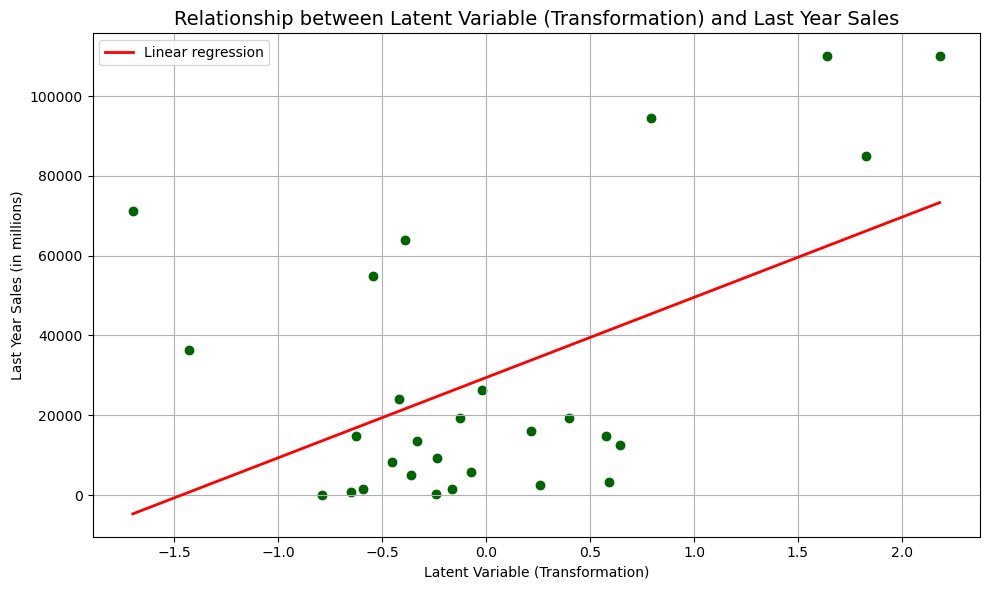

In [52]:
# Specific variables
df_plot = df_analysis_multivariate_final.copy()
x_var = "Indice_Transformation"
y_var = "Last year sales"

# Fit linear regression model
X = df_plot[[x_var]]  # design matrix (2D)
y = df_plot[y_var]
model = LinearRegression().fit(X, y)

# Predict values and compute R²
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_var, y=y_var, data=df_plot, color='darkgreen', s=60)
sns.lineplot(x=df_plot[x_var], y=y_pred, color='red', linewidth=2, label='Linear regression')

# Customize labels and title
plt.title("Relationship between Latent Variable (Transformation) and Last Year Sales", fontsize=14)
plt.xlabel("Latent Variable (Transformation)")
plt.ylabel("Last Year Sales (in millions)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [53]:
df_promedio_empresa_corr=df_analysis_multivariate_final.copy()

# Cammbio de nombre de Indice_Sensing
df_promedio_empresa_corr.rename(columns={'Indice_Transformation': 'Latent variable (Transformation)'}, inplace=True)

# Elegir las columnas que se desean analizar
df_promedio_empresa_corr = df_promedio_empresa_corr[["Latent variable (Transformation)","Company size","Last year sales"]]

categorical_features=identify_nominal_columns(df_promedio_empresa_corr)
continuous_features=identify_numeric_columns(df_promedio_empresa_corr)

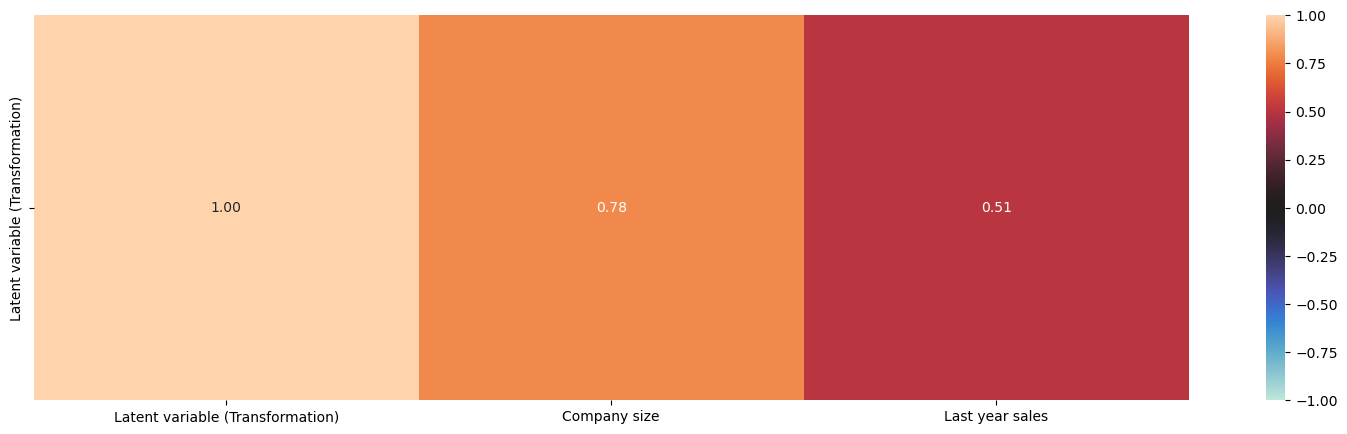

In [54]:
from dython.nominal import associations
target_correlation= associations(df_promedio_empresa_corr, display_rows=["Latent variable (Transformation)"], filename= 'target_correlation.png', figsize=(20,5))

In [55]:
df_promedio_empresa_reg_lineal = df_analysis_multivariate_final[["Indice_Transformation","Last year sales"]]

x=df_promedio_empresa_reg_lineal.drop(["Last year sales"], axis=1)
y=df_promedio_empresa_reg_lineal["Last year sales"]
X = sm.add_constant(x) 
model = sm.OLS(y,X)
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Last year sales   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     8.905
Date:              dom., 01 jun. 2025   Prob (F-statistic):            0.00612
Time:                        18:00:42   Log-Likelihood:                -327.97
No. Observations:                  28   AIC:                             659.9
Df Residuals:                      26   BIC:                             662.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2.945e+04   5798.069      5.079      0.000    1.75e+04    4.14e+04
Indice_Transformation   2.01e+04   6736.981      2.984      0.006    6256.403     3.4e+04
==============================================================================
Omnibus:                        4.816   Durbin-Watson:                   1.764
Prob(Omnibus):                  0.090   Jarque-Bera (JB):                4.219
Skew:                           0.942   Prob(JB):                        0.121
Kurtosis:                       2.741   Cond. No.                         1.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""